# Load module

In [1]:
import sys
sys.path.append('../')

from data import datasets
from data import transforms, target_transforms, augmentations, utils

from ssd.models.ssd512 import SSD512
from ssd.train import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.adam import Adam

# Load Dataset

In [2]:
augmentation = augmentations.AugmentationOriginal()

transform = transforms.Compose(
    [transforms.Resize((512, 512)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.ToCentroids(),
     target_transforms.OneHot(class_nums=datasets.VOC_class_nums, add_background=True),
     target_transforms.ToTensor()]
)
train_dataset = datasets.VOC2007_TrainValDataset(ignore=target_transforms.Ignore(difficult=True), transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)
print('{} training images'.format(len(train_dataset)))

5011 training images


# Define model

In [3]:
model = SSD512(class_labels=train_dataset.class_labels, batch_norm=False).cuda()
model.load_vgg_weights()
print(model)

SSD512(
  (codec): Codec(
    (encoder): Encoder()
    (decoder): Decoder()
  )
  (defaultBox): DBoxSSDOriginal()
  (predictor): Predictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL3

# Set matplotlib for Jupyter notebook

In [4]:
%matplotlib notebook

# Run training

<IPython.core.display.Javascript object>


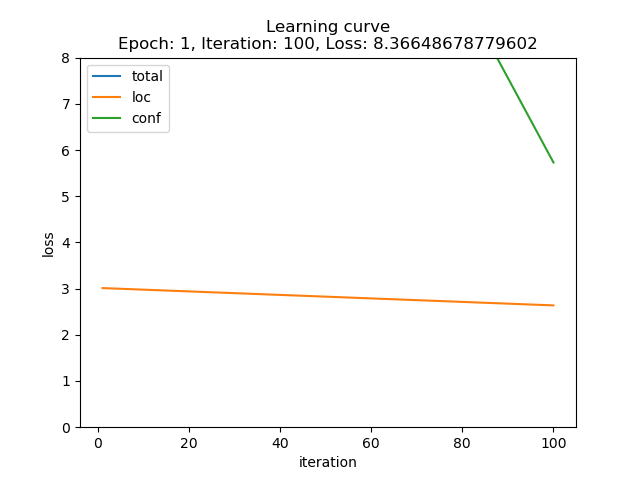

Training... Epoch: 1, Iter: 107,	 [1712/5011	 (34%)]	Loss: 7.554009, Loc Loss: 2.740464, Conf Loss: 4.813546	Iter time: 0.2197

In [ ]:
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # slower
#optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4) # faster
iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(80000, 100000), gamma=0.1, verbose=True)

#save_manager = SaveManager(modelname='ssd300-voc2007++', interval=10, max_checkpoints=15, plot_yrange=(0, 8))#5000
save_manager = SaveManager(modelname='ssd512-voc2007', interval=10000, max_checkpoints=15, plot_yrange=(0, 8))
log_manager = LogManager(interval=100, save_manager=save_manager, loss_interval=100, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=SSDLoss(), optimizer=optimizer, scheduler=iter_sheduler, log_manager=log_manager)

#trainer.train(70, train_loader)
trainer.train(120000, train_loader)